# **Image classification**
Machine learning project for image classification using different types of models. I used 'MedMNIST-Pneumonia' data set for training.
The aim of this project is to train and evaluate one or more classification models in order to establish if the lungs in the images have pneumonia or not.

In [2]:
!pip install keras_tuner

Cell that groups all the libraries used for this project

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

# Imports for data manipulation and model preparation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

# Imports for visualization and presenting results
from IPython.display import Markdown, display
import seaborn as sns
from glob import glob
from PIL import Image
import os
import cv2

# Imports for modeling with Keras
import tensorflow as tf
from tensorflow import keras
import keras_tuner
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import EarlyStopping

In [4]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

I loaded the dataset. The images are stored in the file 'pneumonia_images' and the labels in 'pneumonia_labels'.

In [5]:
# Uploading dataset MedMNIST
try:
    X = np.load("/content/drive/MyDrive/pneumonia_images.npy")
    y = np.load("/content/drive/MyDrive/pneumonia_labels.npy")
except FileNotFoundError:
    print("File not found. Make sure you have the correct path")
    exit()

This code snippet counts the number of normal and pneumonia images, displays a sample of each class, and shows the class distribution.

Image shape: (28, 28)
Total normal images: 1349
Total pneumonia images: 3883


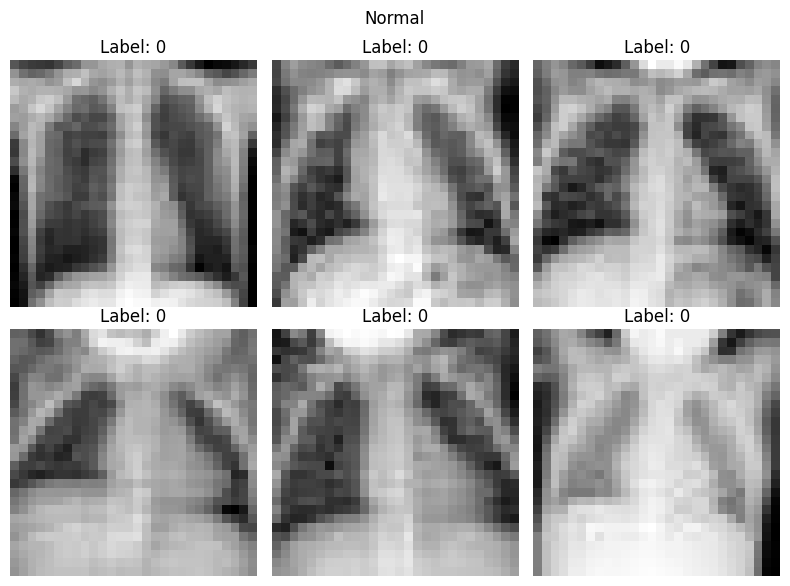

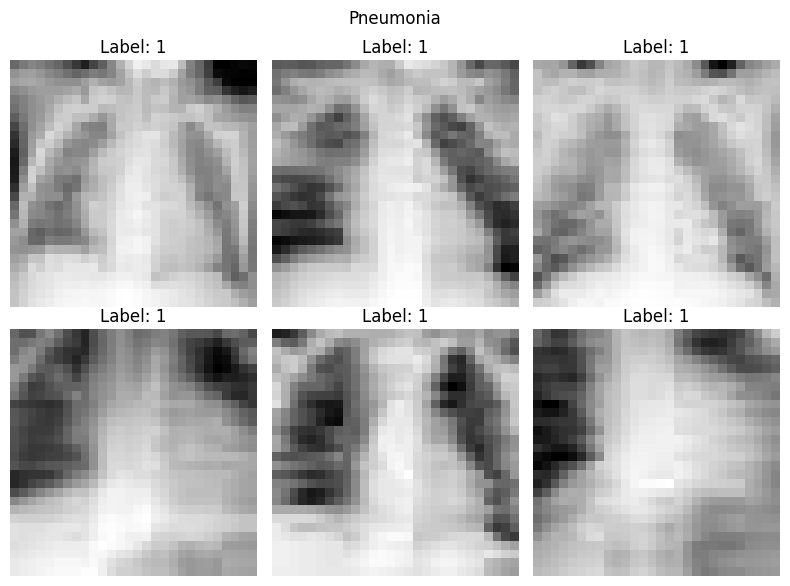

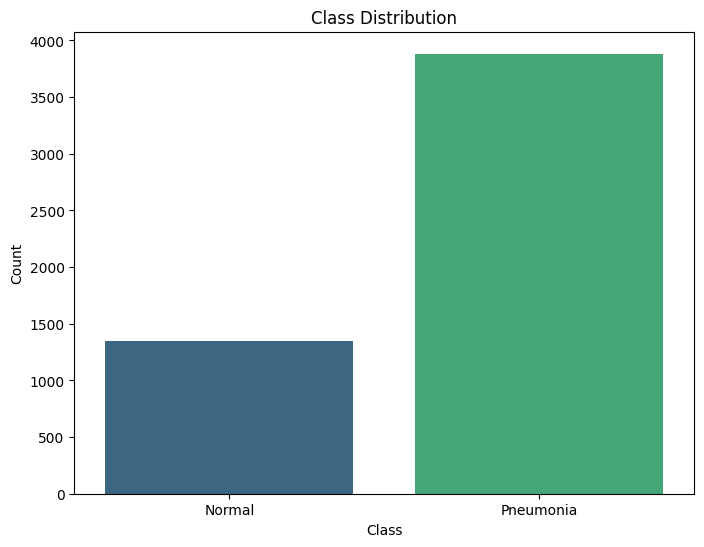

In [6]:
# Check the resolution of images
print(f'Image shape: {X[0].shape}')

# Count the number of images in each class
normal_images_count = np.sum(y == 0)
pneumonia_images_count = np.sum(y == 1)

print(f'Total normal images: {normal_images_count}')
print(f'Total pneumonia images: {pneumonia_images_count}')

# Function to display some images
def show_images(images, labels, label, title):
    plt.figure(figsize=(8,6))
    indices = np.where(labels == label)[0][:6]  # Get the first 6 indices of the specified label
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display some normal images
show_images(X, y, 0, 'Normal')

# Display some pneumonia images
show_images(X, y, 1, 'Pneumonia')

# Distribution of classes
labels = ['Normal', 'Pneumonia']
counts = [normal_images_count, pneumonia_images_count]
data = pd.DataFrame({'Class': labels, 'Count': counts})

plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Count', data=data, palette='viridis', hue='Class', dodge=False, legend=False)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

I randomly split the dataset into training set, validation set and test set. The training set is used to train the different models, the validation set to calculate the errors on new predictions and the test set to verify again the performance of the best models on new data. The split I used is approximately: 70% training set, 15% validation set and 15% test set.

I used the function train_test_split, offered by Scikit-learn for this task, to do a first split of the data and then I did a second split of the temporary set to create all the three sets.

In [7]:
# Division of dataset in training, validation e test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
# Flattening the labels in 1D array
y_train = y_train.ravel()
y_validation = y_validation.ravel()
y_test = y_test.ravel()

I added a channel for the images, because the CNNs used require it.

In [9]:
# If the images are garyscale, add a channel
X_train = np.expand_dims(X_train, axis=-1)
X_validation = np.expand_dims(X_validation, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [10]:
print("Training set dimension:", X_train.shape)
print("Data type:", X_train.dtype)
num_samples, height, width, channels = X_train.shape
print("Number of samples:", num_samples)
print("Image height:", height)
print("Image width:", width)
print("Image number of channels:", channels)

Training set dimension: (3662, 28, 28, 1)
Data type: uint8
Number of samples: 3662
Image height: 28
Image width: 28
Image number of channels: 1


Try to apply some filters to the images. The blur can help identifying the features.

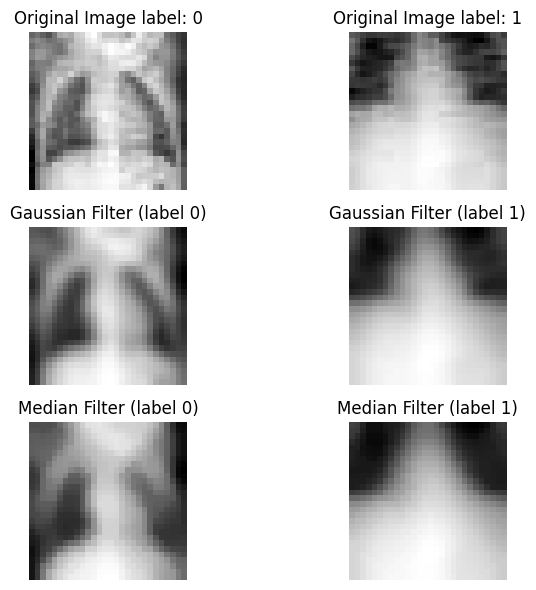

In [11]:
# Randomly select an image with label 0 (normal)
index_label_0 = random.choice(np.where(y == 0)[0])
image_label_0 = X[index_label_0]

# Randomly select an image with label 1 (pneumonia)
index_label_1 = random.choice(np.where(y == 1)[0])
image_label_1 = X[index_label_1]

# Apply Gaussian blur filter for noise reduction
blurred_image_0 = cv2.GaussianBlur(image_label_0, (5, 5), 0)
blurred_image_1 = cv2.GaussianBlur(image_label_1, (5, 5), 0)

# Apply median blur filter for noise reduction
median_filtered_image_0 = cv2.medianBlur(blurred_image_0, 5)
median_filtered_image_1 = cv2.medianBlur(blurred_image_1, 5)

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(8, 6))

# First row: original images
axes[0, 0].imshow(image_label_0, cmap='gray')
axes[0, 0].set_title('Original Image label: 0')
axes[0, 0].axis('off')

axes[0, 1].imshow(image_label_1, cmap='gray')
axes[0, 1].set_title('Original Image label: 1')
axes[0, 1].axis('off')

# Second row: images with Gaussian filter
axes[1, 0].imshow(blurred_image_0, cmap='gray')
axes[1, 0].set_title('Gaussian Filter (label 0)')
axes[1, 0].axis('off')

axes[1, 1].imshow(blurred_image_1, cmap='gray')
axes[1, 1].set_title('Gaussian Filter (label 1)')
axes[1, 1].axis('off')

# Third row: images with median filter
axes[2, 0].imshow(median_filtered_image_0, cmap='gray')
axes[2, 0].set_title('Median Filter (label 0)')
axes[2, 0].axis('off')

axes[2, 1].imshow(median_filtered_image_1, cmap='gray')
axes[2, 1].set_title('Median Filter (label 1)')
axes[2, 1].axis('off')

# Adjust the layout of the subplots to optimize spacing
plt.tight_layout()
plt.show()

# **Random Forest**

Training a Random Forest model using scikit-learn in Python. Use the technique of exhaustive parameter search via GridSearchCV to optimize the model's accuracy.
After training, evaluate the model's performance using accuracy and calculate the RMSE (Root Mean Squared Error) as a measure of discrepancy between observed and predicted values. Finally, measure the processing time taken to train the model.

In [12]:
# Random Forest model
rf_model = RandomForestClassifier(random_state=42)  # 42 is the seed
rf_param_grid = {'n_estimators': [100], 'max_depth': [None]} # 100 trees
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy')

# Training Random Forest
start_time = time.time()
rf_grid_search.fit(X_train.reshape(len(X_train), -1), y_train) # Random Forest requires flattened images
end_time = time.time()

# Considering which model is the best
rf_model_best = rf_grid_search.best_estimator_
rf_pred = rf_model_best.predict(X_validation.reshape(len(X_validation), -1))
rf_accuracy = accuracy_score(y_validation, rf_pred)
rf_conf_matrix = confusion_matrix(y_validation, rf_pred)
rf_class_report = classification_report(y_validation, rf_pred)

# Predictions for the test set
rf_pred_test = rf_model_best.predict(X_test.reshape(len(X_test), -1))
rf_accuracy_test = accuracy_score(y_test, rf_pred_test)
rf_conf_matrix_test = confusion_matrix(y_test, rf_pred_test)
rf_class_report_test = classification_report(y_test, rf_pred_test)

# RMSE
rf_rmse = mean_squared_error(y_validation, rf_pred, squared=False)

# Processing time
rf_processing_time = end_time - start_time

I considered some metrics to decide how this model worked.

The evaluation have been made on the validation set and on the test set to guarantee the model is not overfitting the data.
I obtained high scores for the validation set and similar scores for the test set, so I can says the model fits the data.

In [13]:
print("Random Forest chosen:")
print(rf_model_best)
print("\nAccuracy Random Forest (validation):", rf_accuracy)
print("Classification Report Random Forest:")
print(rf_class_report)

print("\nAccuracy Random Forest (test):", rf_accuracy_test)
print("Classification Report Random Forest:")
print(rf_class_report_test)

Random Forest chosen:
RandomForestClassifier(random_state=42)

Accuracy Random Forest (validation): 0.9426751592356688
Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       220
           1       0.95      0.97      0.96       565

    accuracy                           0.94       785
   macro avg       0.94      0.92      0.93       785
weighted avg       0.94      0.94      0.94       785


Accuracy Random Forest (test): 0.954140127388535
Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       187
           1       0.96      0.98      0.97       598

    accuracy                           0.95       785
   macro avg       0.95      0.92      0.93       785
weighted avg       0.95      0.95      0.95       785



Here is a visual representation of the confusion matrix, which says that the most part of the images has been correctly classificated.

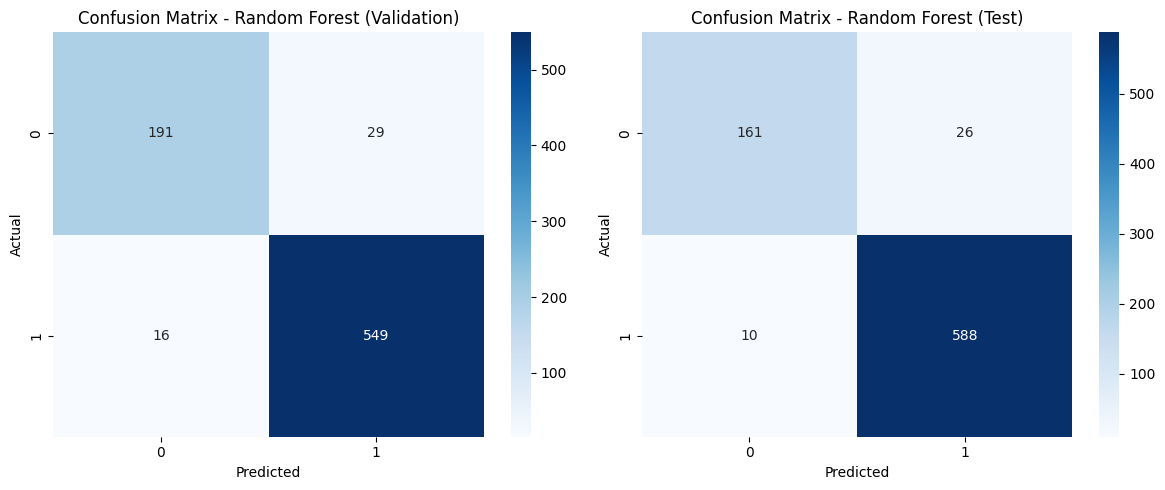

In [15]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(rf_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Create the second subplot in the same 1x2 grid
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(rf_conf_matrix_test, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **Convolutional Neural Network**

The CNN model is defined using the Sequential API from Keras. It consists of convolutional layers (Conv2D) for feature extraction, followed by max pooling (MaxPooling2D) to reduce spatial dimensions. After flattening the feature maps, dense layers (Dense) with ReLU activation functions are employed for further feature processing. The output layer uses a sigmoid activation function to produce probabilities for binary classification.

In this early stopping definition, training stops if the validation loss function doesn't improve for 6 epochs and restore the weights to the values they had with the lower loss function.

In [16]:
# Definition of early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [18]:
# CNN model
CNN_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),  # relu as activation function in hidden layers
    Dense(1, activation='sigmoid')  # 1 output class pneumonia (1) / normal (0), sigmoid as activation function in output layer
])
CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = CNN_model.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation), callbacks=[early_stopping])
end_time = time.time()

# validation set
y_pred_val_cnn = (CNN_model.predict(X_validation) > 0.5).astype("int32")
accuracy_val_cnn = accuracy_score(y_validation, y_pred_val_cnn)
#test set
y_pred_test_cnn = (CNN_model.predict(X_test) > 0.5).astype("int32") # convert the continuous predictions of a binary classification model into discrete class labels
accuracy_test_cnn = accuracy_score(y_test, y_pred_test_cnn)

# Processing time
cnn_processing_time = end_time - start_time

Epoch 1/100
115/115 [==============================] - 3s 10ms/step - loss: 1.4357 - accuracy: 0.8703 - val_loss: 0.1566 - val_accuracy: 0.9401
Epoch 2/100
115/115 [==============================] - 1s 8ms/step - loss: 0.1416 - accuracy: 0.9435 - val_loss: 0.2471 - val_accuracy: 0.9083
Epoch 3/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1211 - accuracy: 0.9544 - val_loss: 0.2735 - val_accuracy: 0.9083
Epoch 4/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1214 - accuracy: 0.9525 - val_loss: 0.1326 - val_accuracy: 0.9490
Epoch 5/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1142 - accuracy: 0.9577 - val_loss: 0.1468 - val_accuracy: 0.9439
Epoch 6/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1075 - accuracy: 0.9577 - val_loss: 0.1156 - val_accuracy: 0.9554
Epoch 7/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1080 - accuracy: 0.9579 - val_loss: 0.1276 - val_accuracy: 0.952

These metrics assert that the CNN is working well with the data. The scores are evaluated on the validation set and are high.

In [19]:
print("CNN:")
print("Accuracy CNN (validation):", accuracy_val_cnn)
print("Accuracy CNN (test):", accuracy_test_cnn)
print("Classification Report CNN:")
print(classification_report(y_validation, y_pred_val_cnn))
print("Classification Report CNN:")
print(classification_report(y_test, y_pred_test_cnn))

CNN:
Accuracy CNN (validation): 0.9656050955414013
Accuracy CNN (test): 0.9605095541401274
Classification Report CNN:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       220
           1       0.97      0.99      0.98       565

    accuracy                           0.97       785
   macro avg       0.96      0.95      0.96       785
weighted avg       0.97      0.97      0.97       785

Classification Report CNN:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       187
           1       0.98      0.97      0.97       598

    accuracy                           0.96       785
   macro avg       0.94      0.95      0.95       785
weighted avg       0.96      0.96      0.96       785



Visual representation of accuracy and loss function through the epochs on the training set and on the validation set.

The accuracy reached for both the sets over 95%.

I represented also the loss function for both training and validation set. The loss on the first set decreased rapidly, while the low values on the validation one states that the model has good proprierties of generalization

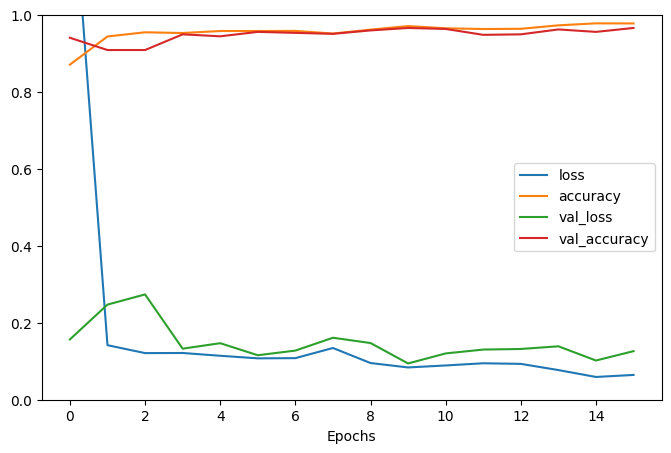

In [20]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel('Epochs')
plt.gca().set_ylim(0, 1)
plt.legend()
plt.show()

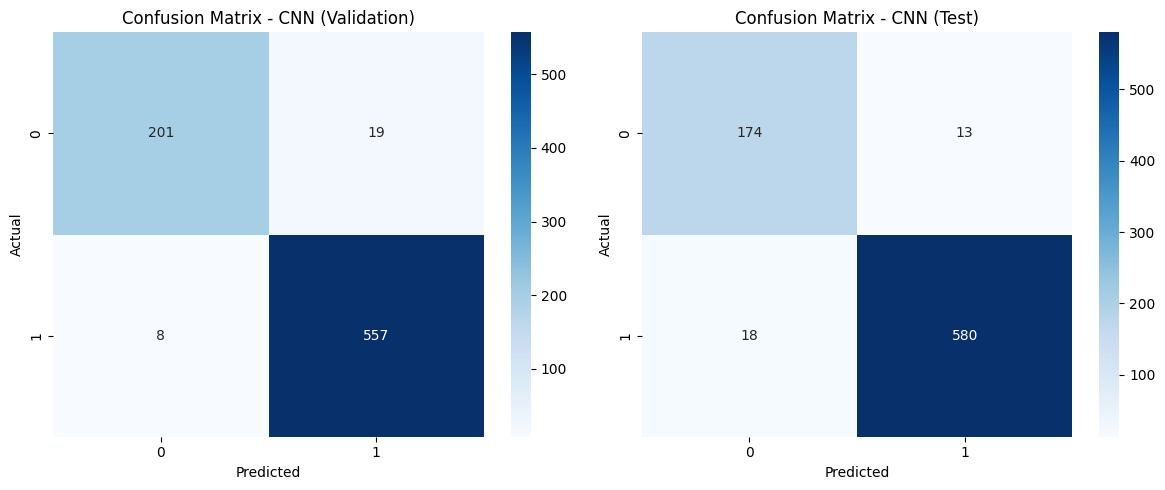

In [32]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(confusion_matrix(y_validation, y_pred_val_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Create the second subplot in the same 1x2 grid
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(confusion_matrix(y_test, y_pred_test_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [33]:
# Function to apply Gaussian filter to the images and keep the labels
def apply_gaussian_filter(X, y):
    filtered_images = []
    for image in X:
        # Apply the filter to every image
        filtered_image = cv2.GaussianBlur(image, (3, 3), 0)
        filtered_images.append(filtered_image)
    return np.array(filtered_images), np.array(y)

# Example usage
filtered_X_train, filtered_y_train = apply_gaussian_filter(X_train, y_train)
filtered_X_validation, filtered_y_validation = apply_gaussian_filter(X_validation, y_validation)
filtered_X_test, filtered_y_test = apply_gaussian_filter(X_test, y_test)

# CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),  # relu as activation function in hidden layers
    Dense(1, activation='sigmoid')  # 1 output class pneumonia (1) / normal (0), sigmoid as activation function in output layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
start_time = time.time()

# Training the model with filtered data
history = model.fit(filtered_X_train, filtered_y_train, epochs=100, validation_data=(filtered_X_validation, filtered_y_validation), callbacks=[early_stopping])

end_time = time.time()

# Predictions
filtered_y_pred_val_cnn = (model.predict(filtered_X_validation) > 0.5).astype("int32")
filtered_y_pred_test_cnn = (model.predict(filtered_X_test) > 0.5).astype("int32") # convert the continuous predictions of a binary classification model into discrete class labels

# Calculate accuracy
filtered_accuracy_val_cnn = accuracy_score(filtered_y_validation, filtered_y_pred_val_cnn)
filtered_accuracy_test_cnn = accuracy_score(filtered_y_test, filtered_y_pred_test_cnn)

# Processing time
filtered_cnn_processing_time = end_time - start_time


Epoch 1/100
115/115 [==============================] - 2s 6ms/step - loss: 2.5516 - accuracy: 0.8121 - val_loss: 0.2035 - val_accuracy: 0.9159
Epoch 2/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1928 - accuracy: 0.9235 - val_loss: 0.1787 - val_accuracy: 0.9299
Epoch 3/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1977 - accuracy: 0.9194 - val_loss: 0.1579 - val_accuracy: 0.9401
Epoch 4/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1467 - accuracy: 0.9435 - val_loss: 0.1376 - val_accuracy: 0.9439
Epoch 5/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1549 - accuracy: 0.9366 - val_loss: 0.1814 - val_accuracy: 0.9389
Epoch 6/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1384 - accuracy: 0.9476 - val_loss: 0.1579 - val_accuracy: 0.9478
Epoch 7/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1330 - accuracy: 0.9503 - val_loss: 0.1309 - val_accuracy: 0.9478

I compared the results obtained without and with filter using CNN, but there are not significant improvements, so I decided to continue with the orginal images.

In [34]:
# Without filter
print("CNN without filter:")
print("Accuracy CNN (validation):", accuracy_val_cnn)
print("CNN without filter:")
print("Accuracy CNN (test):", accuracy_test_cnn)

# With filter
print("\nCNN with filter:")
print("Accuracy CNN (validation):", filtered_accuracy_val_cnn)
print("CNN without filter:")
print("Accuracy CNN (test):", filtered_accuracy_test_cnn)

CNN without filter:
Accuracy CNN (validation): 0.9656050955414013
CNN without filter:
Accuracy CNN (test): 0.9605095541401274

CNN with filter:
Accuracy CNN (validation): 0.9605095541401274
CNN without filter:
Accuracy CNN (test): 0.9707006369426752


I decided to add some reguarization and retrain the model to have some improvements on the classification. I chose a L2 penalty.

In [35]:
# Adding some regularizers to the CNN
CNN_model_reg = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])

# Re-training the model
CNN_model_reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = CNN_model_reg.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation), callbacks=[early_stopping])
cnn_accuracy = CNN_model_reg.evaluate(X_test, y_test)[1]

# validation set
y_pred_val_cnn = (CNN_model_reg.predict(X_validation) > 0.5).astype("int32")
accuracy_val_cnn = accuracy_score(y_validation, y_pred_val_cnn)
#test set
y_pred_test_cnn = (CNN_model_reg.predict(X_test) > 0.5).astype("int32") # convert the continuous predictions of a binary classification model into discrete class labels
accuracy_test_cnn = accuracy_score(y_test, y_pred_test_cnn)

CNN_model_reg.summary()

Epoch 1/100
115/115 [==============================] - 3s 11ms/step - loss: 2.6724 - accuracy: 0.8648 - val_loss: 1.4637 - val_accuracy: 0.8828
Epoch 2/100
115/115 [==============================] - 1s 5ms/step - loss: 1.2307 - accuracy: 0.9388 - val_loss: 1.1310 - val_accuracy: 0.9541
Epoch 3/100
115/115 [==============================] - 1s 5ms/step - loss: 1.0435 - accuracy: 0.9574 - val_loss: 1.0003 - val_accuracy: 0.9529
Epoch 4/100
115/115 [==============================] - 1s 5ms/step - loss: 0.9402 - accuracy: 0.9498 - val_loss: 0.9069 - val_accuracy: 0.9490
Epoch 5/100
115/115 [==============================] - 1s 5ms/step - loss: 0.8490 - accuracy: 0.9517 - val_loss: 0.8061 - val_accuracy: 0.9541
Epoch 6/100
115/115 [==============================] - 1s 5ms/step - loss: 0.7465 - accuracy: 0.9571 - val_loss: 0.8323 - val_accuracy: 0.9197
Epoch 7/100
115/115 [==============================] - 1s 5ms/step - loss: 0.6555 - accuracy: 0.9650 - val_loss: 0.6449 - val_accuracy: 0.954

Looking at the graphic I can see that an improvement has been made. The loss function reaches lower values than before and the two functions for training and validation sets are one the same level after the first epoch.

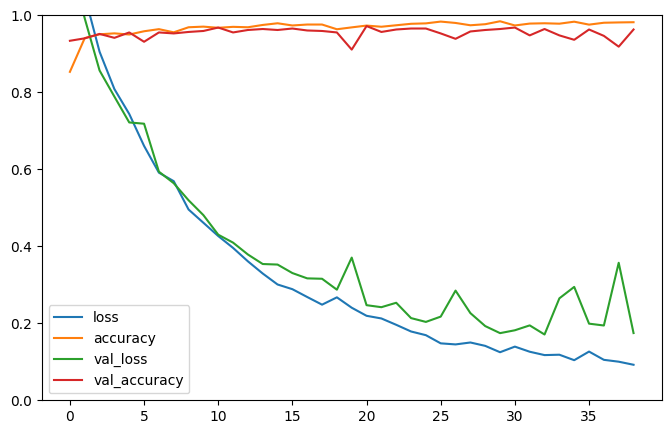

In [29]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.gca().set_ylim(0, 1)
plt.show()

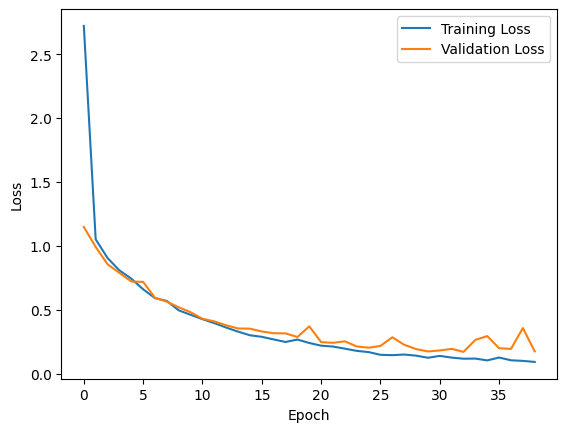

In [30]:
# Loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The confusion matrix of the regularized predictions says that the misclassified images are less than before, when I used a CNN without L2 Penalty.

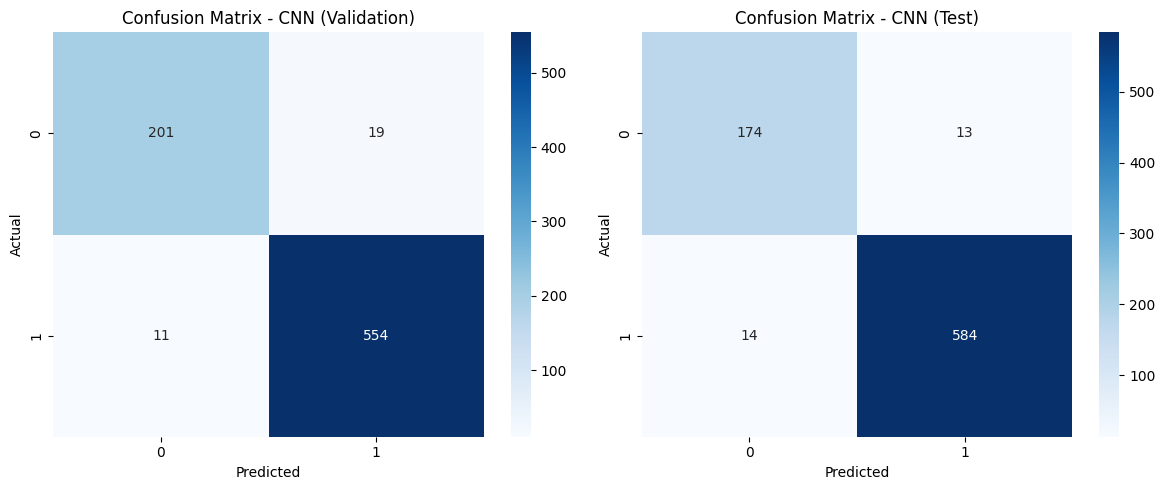

In [37]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(confusion_matrix(y_validation, y_pred_val_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Create the second subplot in the same 1x2 grid
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(confusion_matrix(y_test, y_pred_test_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **K-Nearest Neighbors**

In [43]:
# Reshape every image in X_train to use it in KNN
X_train_flat = np.array([image.reshape(-1) for image in X_train])

# Reshape every image in X_test
X_test_flat = np.array([image.reshape(-1) for image in X_test])

# Define the hyperparameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}  # You can adjust the range of k values as needed

# Create a k-nearest neighbors classifier
knn = KNeighborsClassifier()

# Perform cross-validation to find the best value of k
grid_search = GridSearchCV(knn, param_grid, cv=5)  # 5-fold cross-validation
grid_search.fit(X_train_flat, y_train)

# Get the best value of k
best_k = grid_search.best_params_['n_neighbors']

print("Best value of k:", best_k)

# Create a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=best_k)  # You can adjust the number of neighbors (k) as needed

# Train the classifier on the training data
knn.fit(X_train_flat, y_train)

# Make predictions on the testing data
y_pred_knn = knn.predict(X_test_flat)

# Evaluate the classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)
class_report_knn = classification_report(y_test, y_pred_knn)

# Print the evaluation results
print("Accuracy:", accuracy_knn)
print("Classification Report:")
print(class_report_knn)

Best value of k: 11
Accuracy: 0.9617834394904459
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       187
           1       0.96      0.99      0.98       598

    accuracy                           0.96       785
   macro avg       0.96      0.93      0.95       785
weighted avg       0.96      0.96      0.96       785



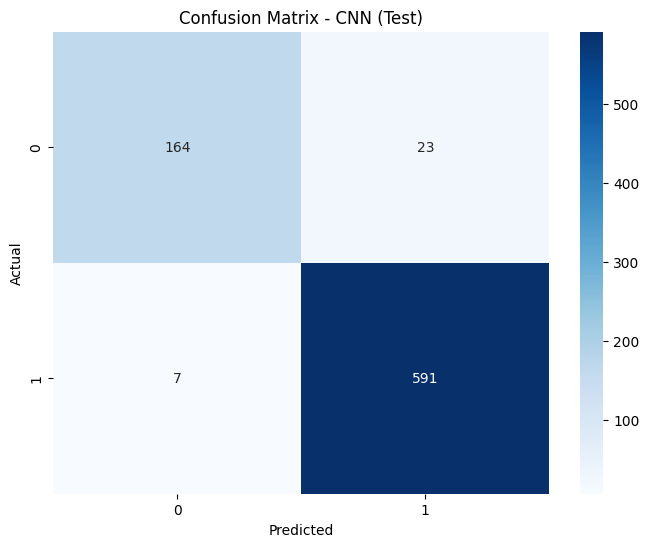

In [44]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_knn, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Logistic regression**

As logistic regression works with 1D data, flatten the features into a single vector for each data point.

In [40]:
# Reshape every image in X_train to use it in Logistic Regression Model
X_train_flat = np.array([image.reshape(-1) for image in X_train])

# Reshape every image in X_test
X_test_flat = np.array([image.reshape(-1) for image in X_test])

# Create a StandardScaler object and fit it to the training data
scaler = RobustScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train_flat)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test_flat)

# Reshape y into a 1D array using reshape(-1)
y_train_1d = y_train.reshape(-1)
y_test_1d = y_test.reshape(-1)

# Verify data are scaled correctly
mean = X_train_scaled[0].mean(axis=0)
print(mean)

std = X_train_scaled[0].std(axis=0)
print(std)

print(y_train_1d)
print(y_test_1d[1:10], '...', y_test_1d[-10:])

-0.4697903096781343
0.5387505561072952
[1 1 1 ... 0 1 1]
[1 1 1 1 1 1 1 1 0] ... [1 1 1 1 1 0 1 0 1 0]


In [41]:
# Create a logistic regression model
log_reg = LogisticRegression(solver='newton-cg')  # Newton's method for optimization. It's suitable for small to medium-sized datasets.

# Train the model on the training data
log_reg.fit(X_train_scaled, y_train_1d)

# Make predictions on the testing data
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy_log_reg = accuracy_score(y_test_1d, y_pred)
conf_matrix = confusion_matrix(y_test_1d, y_pred)
class_report = classification_report(y_test_1d, y_pred)

# Print the evaluation results
print("Accuracy:", accuracy_log_reg)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9592356687898089
Confusion Matrix:
[[171  16]
 [ 16 582]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       187
           1       0.97      0.97      0.97       598

    accuracy                           0.96       785
   macro avg       0.94      0.94      0.94       785
weighted avg       0.96      0.96      0.96       785



# **Model comparison**
I plotted the accuracy for the previous models. The highest values is the CNN one, even if all models have an accuracy over 90%.

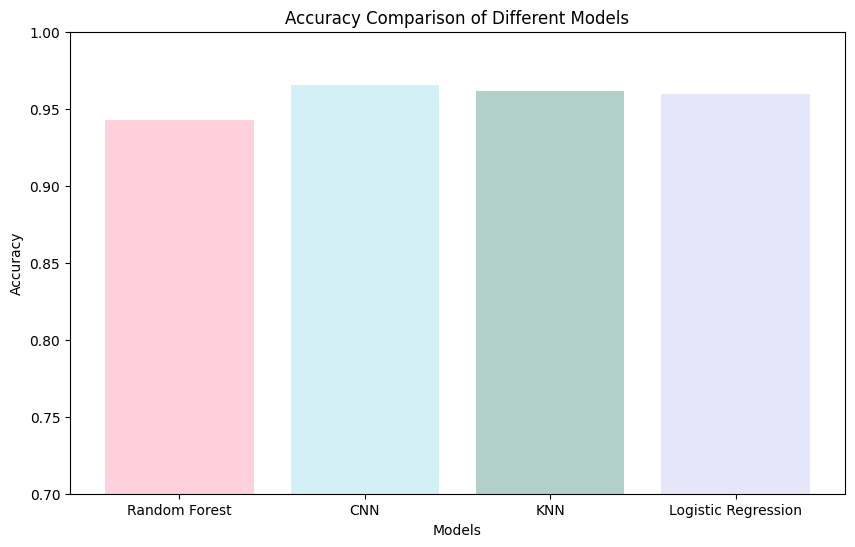

In [45]:
# Accuracy scores for each model
models = ['Random Forest', 'CNN', 'KNN', 'Logistic Regression']
accuracy_scores = [rf_accuracy, cnn_accuracy, accuracy_knn, accuracy_log_reg]  # Example accuracy scores

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_scores, color = ["#ffd1dc", "#d3f0f7", "#b2d0c7", "#e6e6fa"])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0.7, 1)
plt.show()

In [46]:
# Create a dictionary to store predicted probabilities for each model
predicted_probs = {
    'Random Forest': rf_model_best.predict_proba(X_test_scaled)[:, 1],
    'CNN': CNN_model_reg.predict(X_test),
    'KNN': knn.predict_proba(X_test_scaled)[:, 1],
    'Logistic Regression': log_reg.predict_proba(X_test_scaled)[:, 1]
}

25/25 [==============================] - 0s 2ms/step


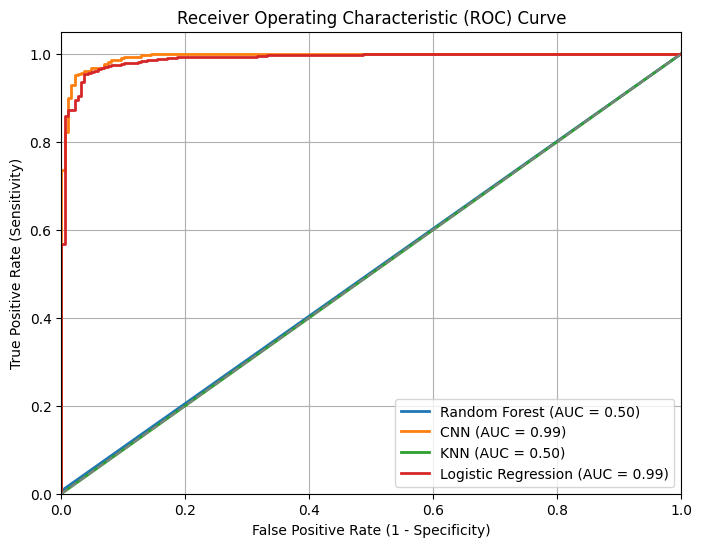

In [47]:
model_predictions = {
    'Random Forest': (predicted_probs['Random Forest'], y_test),
    'CNN': (predicted_probs['CNN'], y_test),
    'KNN': (predicted_probs['KNN'], y_test),
    'Logistic Regression': (predicted_probs['Logistic Regression'], y_test)
}

# Plot ROC curve for each model
plt.figure(figsize=(8, 6))
for model_name, (predicted_probs, y_test) in model_predictions.items():
    if isinstance(predicted_probs, tuple):  # If predicted_probs is a tuple
        predicted_probs = predicted_probs[0]  # Get the first element of the tuple
    if predicted_probs.ndim == 1:  # If predicted_probs is a 1D array (binary classification)
        fpr, tpr, _ = roc_curve(y_test, predicted_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    else:  # If predicted_probs is a 2D array (multiclass classification)
        # Assuming we have binary classification for each class vs the rest
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(predicted_probs.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test, predicted_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2, label=f'{model_name} (AUC = {roc_auc[i]:.2f})')

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**ROC Curve Analysis**

ROC curves assessed model performance (Random Forest, CNN, KNN, Logistic Regression). The CNN achieved the highest AUC, indicating better differentiation between normal and pneumonia cases in the MedMNIST dataset. Logistic Regression works nearly as good ad the CNN. KNN and Random Forest showed more room for improvement as their curves approached the random classifier line.

# **F1-score**
F1-score is particularly useful for imbalanced datasets, where there might be a significant difference in the number of positive and negative examples. This is the case of MedMNIST Pneumonia data set, in which we have more pneumonia images than normal ones, as showed at the beginning.

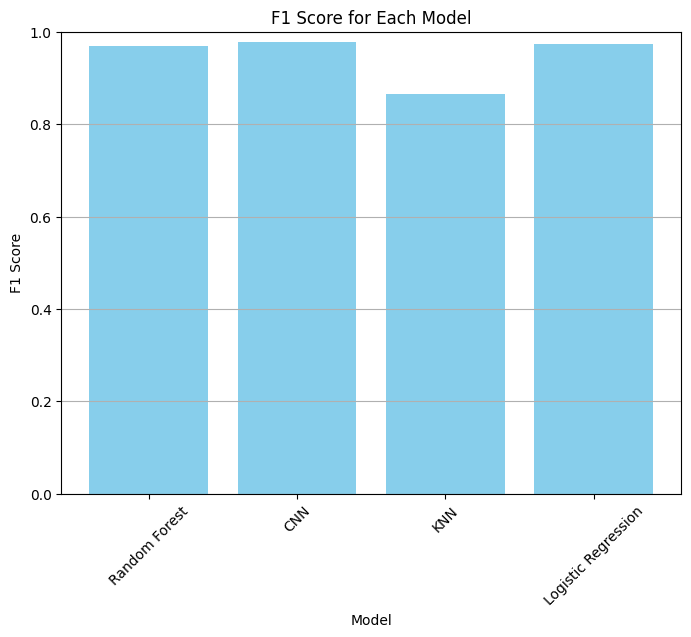

In [50]:
# Predictions for the test set
rf_probs_test = rf_model_best.predict_proba(X_test.reshape(len(X_test), -1))[:, 1]

# Add Random Forest predictions to the model_predictions dictionary
model_predictions['Random Forest'] = (rf_probs_test, y_test)

# Calculate F1 score for each model
model_f1_scores = {}
for model_name, (predicted_probs, y_test) in model_predictions.items():
    y_pred = (predicted_probs > 0.5).astype(int)  # Convert probabilities to binary predictions
    f1 = f1_score(y_test, y_pred)
    model_f1_scores[model_name] = f1

# Plot F1 score for each model
plt.figure(figsize=(8, 6))
plt.bar(model_f1_scores.keys(), model_f1_scores.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Model')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


Looking at the plot, I can assert that CNN is the model that achieved the best results, as it has the highest F1-score. The other models have high scores too. The worst one is KNN, even if its score is near 90%.